<a href="https://colab.research.google.com/github/eridanletalis/geekbrains_ab/blob/main/hw_ab_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3>
На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.</h3>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from scipy.stats import ttest_1samp
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [7]:
data = pd.read_excel('/content/drive/MyDrive/geekbrains_course/AB_Test_Results.xlsx')

data.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


Проверим на дубли по user_id и исключим сразу же
Суть метода в том, что пользователи группируются по VARIANT_NAME. Пользователи, которые есть и в группе variant и control, должны быть исключены.

In [34]:
v = data.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [35]:
v

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
...,...,...
6319,9993,1
6320,9995,1
6321,9996,2
6322,9998,1


In [37]:
more_than_one_types = v.query('VARIANT_NAME > 1')
more_than_one_types

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


In [38]:
df = data[~data.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [39]:
df.head()

,USER_ID,VARIANT_NAME,REVENUE
3479,2,control,0.0
7076,2,control,0.0
2406,2,control,0.0
9077,4,variant,0.0
9155,5,variant,0.0


In [40]:
data = df

In [41]:
data.describe()

,USER_ID,REVENUE
count,6070.000000,6070.000000
mean,4983.664086,0.107064
std,2897.990118,2.673501
min,2.000000,0.000000
25%,2472.250000,0.000000
50%,4950.000000,0.000000
75%,7501.000000,0.000000
max,9998.000000,196.010000


Из 10 000 записей осталось 6070. Около 40%. Первая рекомендация: проверить, всё ли в порядке с расделителем на группы, возможно ошибка. 

In [42]:
data.VARIANT_NAME.value_counts()

variant    3044
control    3026
Name: VARIANT_NAME, dtype: int64

In [43]:
var_df = data[data['VARIANT_NAME'] == 'variant']
ctrl_df = data[data['VARIANT_NAME'] == 'control']

In [46]:
var_df[var_df.REVENUE > 0.0].shape

(43, 3)

In [47]:
ctrl_df[ctrl_df.REVENUE > 0.0].shape

(54, 3)

In [48]:
# Статистика по всем пользователям для В
var_df.REVENUE.describe()

count    3044.000000
mean        0.058909
std         0.760344
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        23.040000
Name: REVENUE, dtype: float64

In [52]:
# Статистика только по совершившим покупку для Б
var_df[var_df.REVENUE > 0.0].REVENUE.describe()

count    43.000000
mean      4.170233
std       4.932851
min       0.020000
25%       1.250000
50%       2.720000
75%       4.270000
max      23.040000
Name: REVENUE, dtype: float64

In [53]:
# Статистика по всем пользователям для А
ctrl_df.REVENUE.describe()

count    3026.000000
mean        0.155506
std         3.708620
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       196.010000
Name: REVENUE, dtype: float64

In [54]:
# Статистика только по совершившим покупку для А
ctrl_df[ctrl_df.REVENUE > 0.0].REVENUE.describe()

count     54.000000
mean       8.714074
std       26.627446
min        0.020000
25%        1.585000
50%        3.120000
75%        6.007500
max      196.010000
Name: REVENUE, dtype: float64

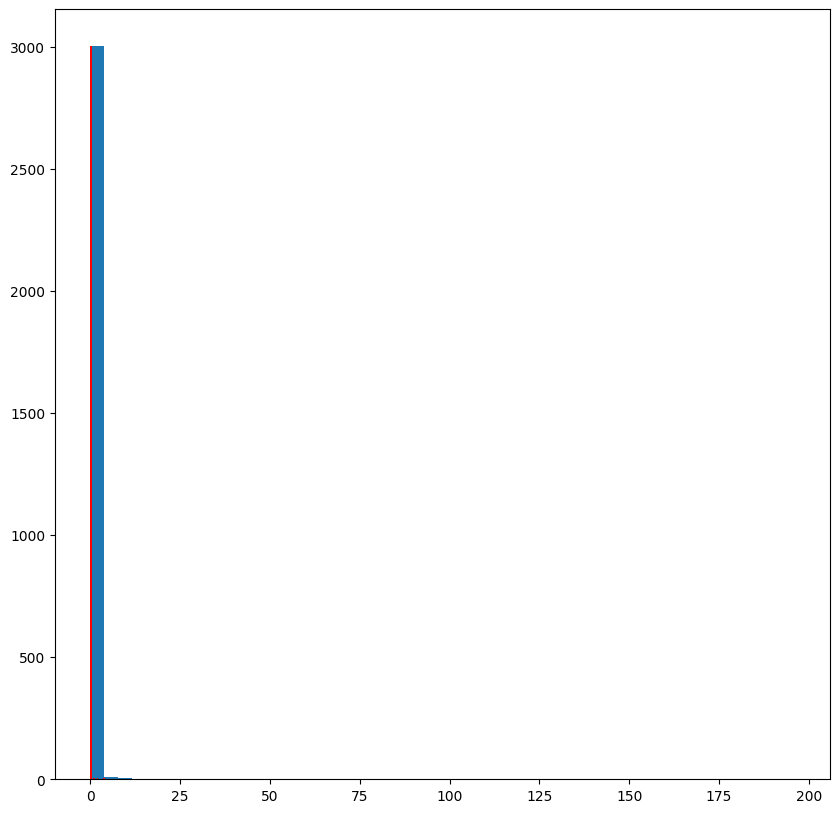

In [60]:
# Смотрим на распределения (красные - группа Б)
plt.figure(figsize=(10, 10))
plt.hist(ctrl_df.REVENUE,  bins=50)
plt.hist(var_df.REVENUE, color='r', bins=50)
plt.show()

Купивших слишком мало. Уже вторая "метка", что стоит изменить дизайн эксперимента, например, добавив условие, что собираются только те данные, где есть покупка. Также нужно посмотреть, как долго длился тест. Скорее всего не достаточно долго.

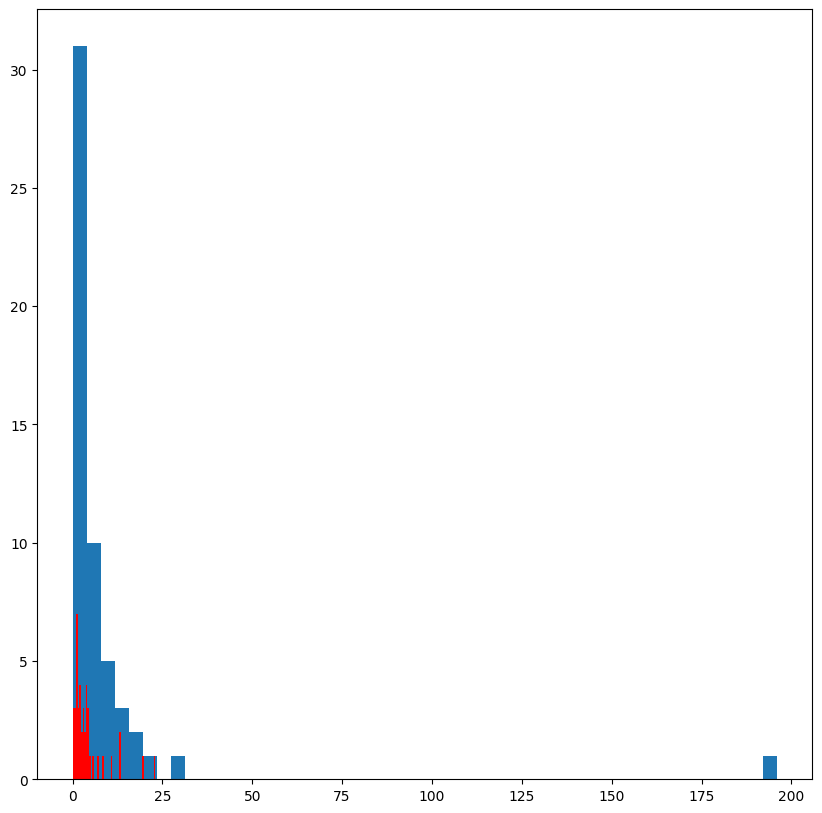

In [59]:
# Смотрим на распределения для купивших (красные - Б)
plt.figure(figsize=(10, 10))

plt.hist(ctrl_df[ctrl_df.REVENUE > 0.0].REVENUE,  bins=50)
plt.hist(var_df[var_df.REVENUE > 0.0].REVENUE, color='r', bins=50)

plt.show()

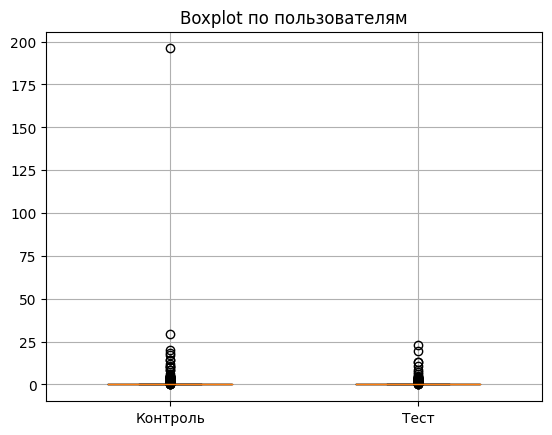

In [62]:
# Боксплот, чтобы посмотреть на выбросы
plt.boxplot([ctrl_df.REVENUE,var_df.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Данных мало, однозначно, распределения не нормальные, есть выбросы. По гистограммам видно, что группа Б даже хуже, чем группа А. Однозначно, либо не вводить изменения, либо проверить, что протестировано верно.

Для проверки нормальности используем критерий Шапиро-Уилка

In [61]:
from scipy.stats import shapiro

alpha = 0.05

st = shapiro(data.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



Подтвердили предположение о ненормальности данных. Используем критерий Манна-Уитни, т.к. данные не нормальные, в каждой группе их мало и существуют выбросы.

In [64]:
from scipy.stats import mannwhitneyu
mannwhitneyu (ctrl_df.REVENUE, var_df.REVENUE, alternative='two-sided')

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

Т.к. p_value не меньше уровня значимости, то нулевую гипотезу о равных выборках мы отвергнуть не можем.

Посчитаем, достаточна ли была мощность наших выборок, чтобы анализировать результаты

In [66]:
C_mean = ctrl_df.REVENUE.values.mean()

T_mean = var_df.REVENUE.values.mean()


C_std = ctrl_df.REVENUE.values.std()

T_std = var_df.REVENUE.values.std()

n =  len(ctrl_df.REVENUE.values)

In [67]:
S = np.sqrt((T_std**2 + C_std **2)/ 2)
S

2.6764947104039547

In [68]:
ef =float((T_mean-C_mean)/ S) 
ef

-0.0360905955737073

In [69]:
from statsmodels.stats.power import TTestIndPower

In [70]:
power = TTestIndPower().solve_power(effect_size=ef,
                                    power=None,
                                    nobs1=n,
                                    ratio=1.0,
                                    alpha=0.05,
                                    alternative='smaller')
power

0.4047063221863162

Мощности выборок были достаточны.

В итоге рекомендацией является либо не вводит изменений, на которых происходило тестирование группы Б, либо уточнить дизайн А/В теста, т.к. 


1.   Очень маленькая выборка среди тех, кто совершил покупку в относительном выражении
2.   Большая, около 40%, часть некорректной информации (дубли).
3.   По анализу данных текущего эксперимента выходит, что внесение изменений не улучшит показатель дохода, возможно, ухудшит (см. распределение для купивших выше). 

